# Разработка A/B-тестирования и анализ результатов

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В нашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Требуется рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

В нашем распоряжении есть 3 таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе требуется импортировать нужные библиотеки, загрузить наши файлы и ознакомиться с данными.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy import stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    df = pd.read_csv("https://code.s3.yandex.net/datasets/sessions_project_history.csv")
    print("Файл успешно загружен")
    print(f"Размер данных: {df.shape}")
    
except FileNotFoundError:
    print("Ошибка: Файл не найден! Проверьте путь к файлу.")
    
display(df.head(5))

Файл успешно загружен
Размер данных: (435924, 10)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
df_grouped = df.groupby('user_id')['session_id'].nunique().sort_values(ascending = False)
df_max = df_grouped.max()
users_with_max = df_grouped[df_grouped == df_max].index
selected_user = users_with_max[0]
result = df[df['user_id'] == selected_user]
display(result)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, требуется визуализировать, как менялось число регистраций в приложении за время его существования.

- Требуется рассчитать число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Считаем, что у каждого пользователя максимум 1 сессия и флаг регистрации за 1 день не меняется.

- Построить линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. 

- Построить отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [4]:
df_date = df.groupby('session_date')['user_id'].nunique()
df_date = df_date.sort_index()
display(df_date)

session_date
2025-08-11     3919
2025-08-12     6056
2025-08-13     8489
2025-08-14    10321
2025-08-15    14065
2025-08-16    12205
2025-08-17    11200
2025-08-18    10839
2025-08-19    12118
2025-08-20    13514
2025-08-21    15051
2025-08-22    17563
2025-08-23    16082
2025-08-24    13683
2025-08-25    13635
2025-08-26    13289
2025-08-27    14766
2025-08-28    15388
2025-08-29    16873
2025-08-30    14891
2025-08-31    13266
2025-09-01    12685
2025-09-02    12672
2025-09-03    12777
2025-09-04    13683
2025-09-05    15324
2025-09-06    13078
2025-09-07    12367
2025-09-08    11826
2025-09-09    11780
2025-09-10    12526
2025-09-11     8623
2025-09-12     6436
2025-09-13     5183
2025-09-14     4364
2025-09-15     3698
2025-09-16     3032
2025-09-17     2548
2025-09-18     1952
2025-09-19     1418
2025-09-20     1100
2025-09-21      776
2025-09-22      546
2025-09-23      317
Name: user_id, dtype: int64

In [5]:
df_reg = df.groupby('session_date')['registration_flag'].sum()
df_reg = df_reg.sort_index()
display(df_reg)

session_date
2025-08-11     169
2025-08-12     336
2025-08-13     464
2025-08-14     625
2025-08-15     840
2025-08-16     916
2025-08-17     833
2025-08-18     860
2025-08-19     831
2025-08-20    1008
2025-08-21    1063
2025-08-22    1251
2025-08-23    1253
2025-08-24    1181
2025-08-25    1060
2025-08-26    1050
2025-08-27    1076
2025-08-28    1175
2025-08-29    1174
2025-08-30    1165
2025-08-31    1105
2025-09-01    1028
2025-09-02    1039
2025-09-03    1035
2025-09-04    1007
2025-09-05    1030
2025-09-06    1023
2025-09-07    1069
2025-09-08    1009
2025-09-09     980
2025-09-10    1015
2025-09-11     824
2025-09-12     669
2025-09-13     537
2025-09-14     440
2025-09-15     383
2025-09-16     286
2025-09-17     272
2025-09-18     201
2025-09-19     132
2025-09-20     107
2025-09-21      87
2025-09-22      68
2025-09-23      32
Name: registration_flag, dtype: int64

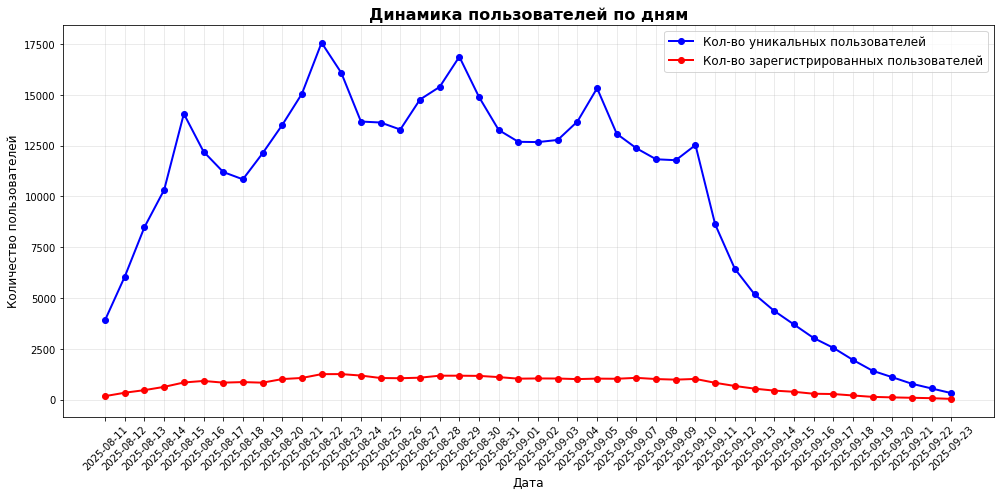

In [6]:
plt.figure(figsize=(14, 7))

plt.plot(df_date.index, df_date.values, 
         label='Кол-во уникальных пользователей', 
         marker='o', 
         linewidth=2,
         color='blue')

plt.plot(df_reg.index, df_reg.values, 
         label='Кол-во зарегистрированных пользователей', 
         marker='o', 
         linewidth=2,
         color='red')

# Настройки графика
plt.title('Динамика пользователей по дням', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

<div class="alert alert-block alert-success">
    
Комментарии к графику: 
    
На графике наблюдаются как подъемы так и падения кол-ва уникальных пользователей, что говорит о общей нестабильности измеряемой величины.
    
Подъемы наблюдаются в даты: 14.08.2025, 21.08.2025, 28.08.2025, 04.09.2025, 09.09.2025. Можно заметить, что все эти даты являются четвергами. 
    
Помимо этого можно заметить, что общее кол-во уникальных и зарегистрированных пользователей падает к концу наблюдаемого периода.

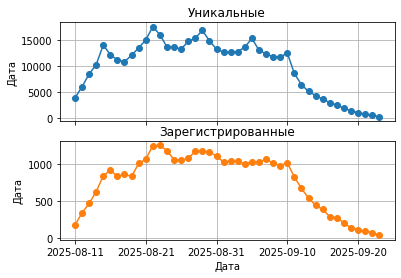

In [7]:
df_agg = df.groupby('session_date').agg({'user_id' : 'nunique', 'registration_flag' : 'sum'})
axes = df_agg.plot(kind='line',
                   subplots=True,
                   sharex=True,
                   sharey=False,
                   legend=False,
                   marker='o', # Установка маркера для точек
                   title=['Уникальные', 'Зарегистрированные'])

# Устанавливаем подпись для оси Y каждого из подграфиков
axes[0].set_ylabel('Дата')
axes[1].set_ylabel('Дата')

# Включаем сетку для каждого из подграфиков
axes[0].grid(which='both')
axes[1].grid(which='both')

# Подписываем ось X
plt.xlabel('Дата')
plt.show()

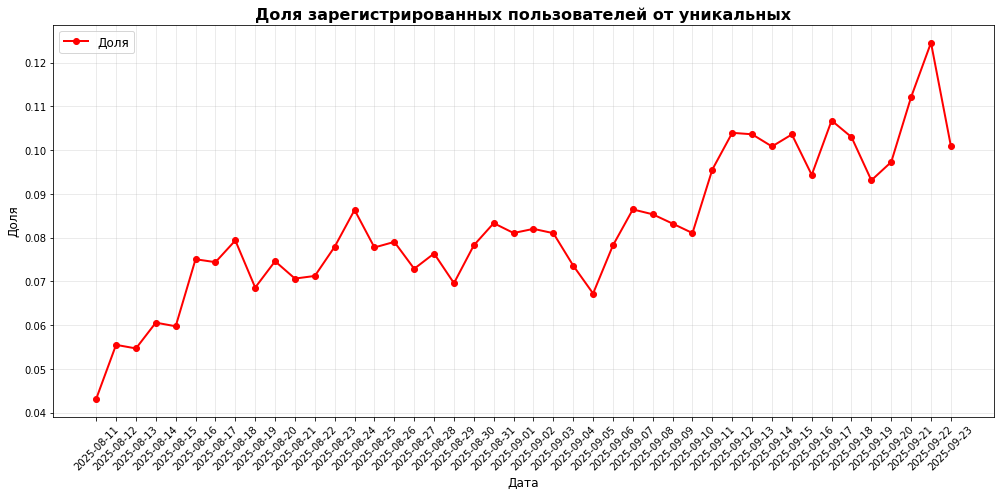

In [8]:
df_part = df_reg / df_date
plt.figure(figsize=(14, 7))

plt.plot(df_part.index, df_part.values, 
         label='Доля', 
         marker='o', 
         linewidth=2,
         color='red')

# Настройки графика
plt.title('Доля зарегистрированных пользователей от уникальных', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

<div class="alert alert-block alert-success">

Комментарии к графику:

Как видно на графике выше, доля зарегистрированных пользователей от уникальных стремительно растет. 

На момент начала наблюдаемого периода эта доля составляла около 0.04, когда на конец периода она возросла до 0.1. 

Смотря на график, можно сделать вывод, что данный рост не является стабильным - видны резкие спады и подъемы наблюдаемой метрики.

#### 1.4. Анализ числа просмотренных страниц
Проанализируем число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найти количество сессий для каждого значения количества просмотренных страниц. 

- Построить наиболее подходящую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [9]:
df_page = df.groupby('page_counter')['session_id'].nunique()
display(df_page)

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

<AxesSubplot:title={'center':'Число просмотренных страниц'}, xlabel='page_counter', ylabel='Кол-во сессий'>

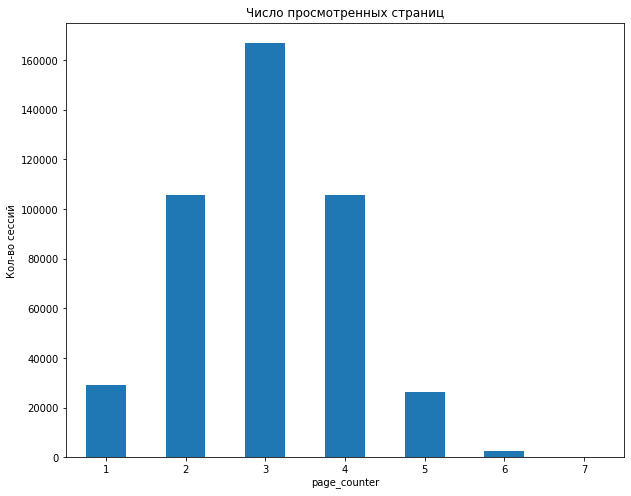

In [10]:
df_page.plot(
    kind = 'bar',
    title = 'Число просмотренных страниц',
    figsize = (10, 8),
    rot = 0,
    ylabel = 'Кол-во сессий')

<div class="alert alert-block alert-success">

Комментарии к графику:
    
По графику видно, что большее кол-во сессий завершилось просмотром 3 страниц - 166690 шт.  
    
Далее по располагаются сессии, которые завершились после просмотра 4 и 2 страниц - 105569 шт. и 105536 шт. соответственно. 
    
Сессии с 6 и 7 страницами имеют наименьшие показатели - 2589 шт. и 92 шт. соответственно.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построить график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [11]:
df['good_session'] = (df['page_counter'] >= 4).astype(int)
display(df.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


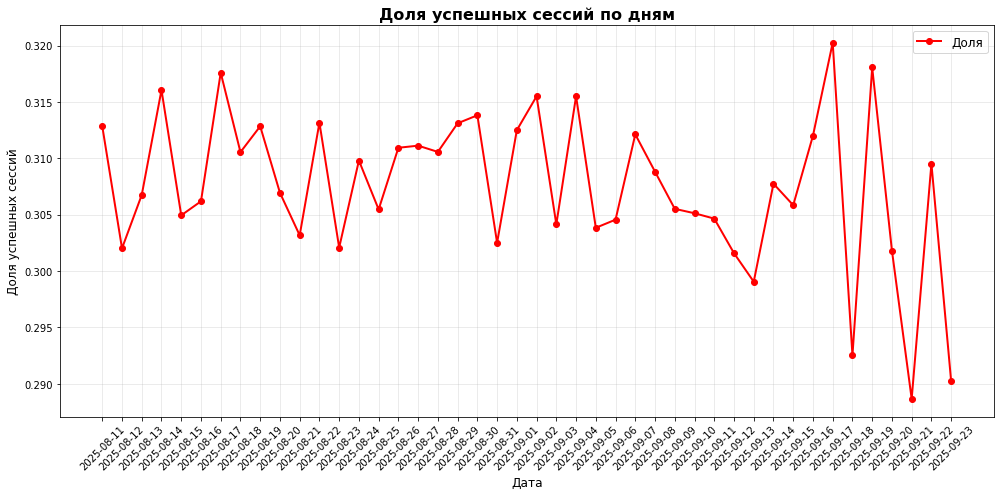

In [12]:
df_good = df.groupby('session_date')['good_session'].sum()
df_all = df.groupby('session_date')['session_id'].count()
df_part2 = df_good / df_all

plt.figure(figsize=(14, 7))

plt.plot(df_part2.index, df_part2.values, 
         label='Доля', 
         marker='o', 
         linewidth=2,
         color='red')

# Настройки графика
plt.title('Доля успешных сессий по дням', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля успешных сессий', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

<div class="alert alert-block alert-success">

Комментарии к графику:
    
На графике представлена доля успешных сессий по дням в наблюдаемом периоде. 

Несмотря на нестабильный вид графика, значений долей успешных сессий по дням в основном находятся в интервале от 0.29 до 0.32. 
    
Максимальная доля успешных сессий была 16.09.2025. 
    
Минимальная доля успешных сессий была 20.09.2025г. 

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.


Сформулируем нулевую и альтернативную гипотезы:

Исследуемая метрика: Кол-во успешных сессий (более 4 страниц)

Нулевая гипотеза (H₀)
Новый алгоритм не повлиял на кол-во успешных сессий

Альтернативная гипотеза (H₁)
Новый алгоритм увеличил кол-во успешных сессий (правосторонняя альтернативная гипотеза)




#### 2.2. Расчёт размера выборки
Рассчитаем необходимое для нашего эксперимента количество пользователей.

Установим следующие параметры для проведения эксперимента:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

In [13]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста
Рассчитаем длительность теста, разделив кол-во пользователей в каждой выборке на среднее кол-во пользователей приложения:

In [14]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = df.groupby('session_date')['user_id'].nunique().mean()
print(avg_daily_users)
# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

9907.363636363636
Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Для большего понимания, построим визуализацию, на которой будет видно возможное различие двух групп.

In [15]:
try:
    sessions_test_part = pd.read_csv("https://code.s3.yandex.net/datasets/sessions_project_test_part.csv")
    print("Файл успешно загружен")
    print(f"Размер данных: {df.shape}")
    
except FileNotFoundError:
    print("Ошибка: Файл не найден! Проверьте путь к файлу.")
    
display(sessions_test_part.head(5))

Файл успешно загружен
Размер данных: (435924, 11)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [16]:
daily_users_by_group = sessions_test_part.groupby('test_group')['user_id'].nunique()
display(daily_users_by_group)

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [17]:
count_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
count_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
display(count_a)
display(count_b)

1477

1466

In [18]:
distinction = (abs(count_a - count_b) / count_a)*100
display(distinction)

0.7447528774542992

<AxesSubplot:title={'center':'Кол-во уникальных пользователей в группах А и В'}, xlabel='test_group', ylabel='Кол-во пользователей'>

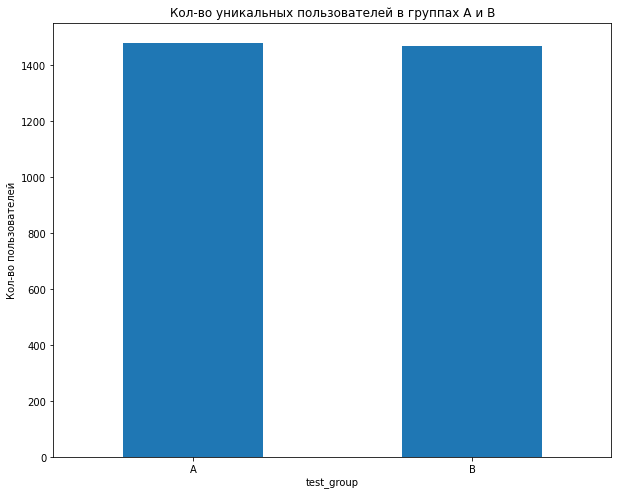

In [19]:
daily_users_by_group.plot(
    kind = 'bar',
    title = 'Кол-во уникальных пользователей в группах А и В',
    figsize = (10, 8),
    rot = 0,
    ylabel = 'Кол-во пользователей')

<div class="alert alert-block alert-success">
Вывод: кол-во пользователей в обеих выборках незначительно отличается (0.74%), что говорит о том, что мы имеем дело с отличным распределением.

#### 3.2. Проверка пересечений пользователей
Убедимся в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

In [20]:
users_in_a = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
users_in_b = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())
share_users = users_in_a.intersection(users_in_b)
if len(share_users) == 0:
    print("Нет пользователей, которые встречаются в обеих группах") 
else:
    print(f"Количество пользователей в обеих группах: {len(share_users)}")

Нет пользователей, которые встречаются в обеих группах


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.


In [21]:
df_group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
df_device_a = df_group_a.groupby('device')['user_id'].nunique()
display(df_device_a)

device
Android    656
Mac        156
PC         369
iPhone     296
Name: user_id, dtype: int64

In [22]:
df_part_a = df_device_a / count_a
display(df_part_a)

device
Android    0.444144
Mac        0.105619
PC         0.249831
iPhone     0.200406
Name: user_id, dtype: float64

In [23]:
df_group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']
df_device_b = df_group_b.groupby('device')['user_id'].nunique()
display(df_device_b)

device
Android    668
Mac        148
PC         381
iPhone     269
Name: user_id, dtype: int64

In [24]:
df_part_b = df_device_b / count_b
display(df_part_b)

device
Android    0.455662
Mac        0.100955
PC         0.259891
iPhone     0.183492
Name: user_id, dtype: float64

In [25]:
df_comparison = pd.concat([df_part_a, df_part_b], axis=1, keys=['Доля A', 'Доля B']).fillna(0)

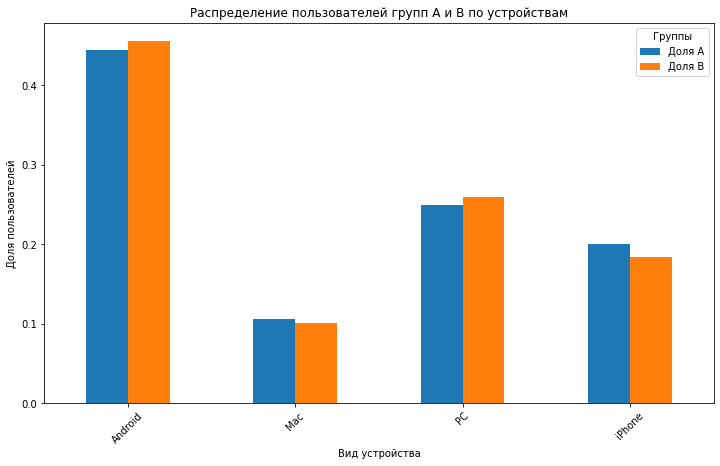

In [26]:
ax = df_comparison.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Вид устройства')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей групп А и В по устройствам')

# Показываем график
plt.xticks(rotation=45)
plt.legend(title='Группы')
plt.show()

<div class="alert alert-block alert-success">
Вывод: кол-во пользователей в обеих выборках незначительно отличается, что говорит о том, что пользователи обеих выборок нормально распределены.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построем две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


In [27]:
df_region_a = df_group_a.groupby('region')['user_id'].nunique()
display(df_region_a)

region
CIS     644
EU      224
MENA    609
Name: user_id, dtype: int64

In [28]:
df_part_a1 = df_region_a / count_a
display(df_part_a1)

region
CIS     0.436019
EU      0.151659
MENA    0.412322
Name: user_id, dtype: float64

In [29]:
df_region_b = df_group_b.groupby('region')['user_id'].nunique()
display(df_region_b)

region
CIS     645
EU      217
MENA    604
Name: user_id, dtype: int64

In [30]:
df_part_b1 = df_region_b / count_b
display(df_part_b1)

region
CIS     0.439973
EU      0.148022
MENA    0.412005
Name: user_id, dtype: float64

In [31]:
df_comparison1 = pd.concat([df_part_a1, df_part_b1], axis=1, keys=['Доля A', 'Доля B']).fillna(0)

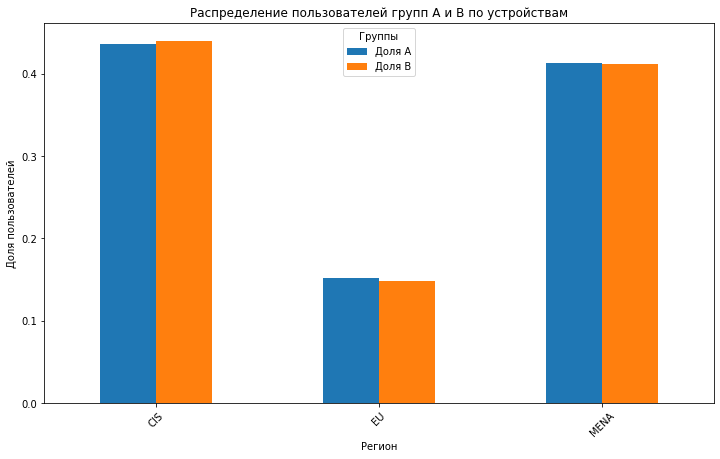

In [32]:
ax1 = df_comparison1.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей групп А и В по устройствам')

# Показываем график
plt.xticks(rotation=45)
plt.legend(title='Группы')
plt.show()

<div class="alert alert-block alert-success">
Вывод: кол-во пользовательей в обеих выборках незначительно отличается, что говорит о том, что пользователи обеих выборок нормально распределены.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируем свои выводы.

<div class="alert alert-block alert-success">
    
**Вывод:**
    
1. Кол-во пользователей в обеих выборках незначительно отличается (0.74%), что говорит о том, что мы имеем дело с отличным распределением.
2. Пользователей, которые бы были одновременно в двух группах не обнаружено, что говорит не зависимости обеих выборок. 
3. Исходя из анализа по регионам и устройствам видно, что кол-во пользователей каждой из групп распределено нормально. 

**Резюмируя вышеописанное, можно утверждать, что А/И тест проходит нормально, нарушений не наблюдается.**

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [33]:
try:
    sessions_test = pd.read_csv("https://code.s3.yandex.net/datasets/sessions_project_test.csv")
    print("Файл успешно загружен")
    print(f"Размер данных: {df.shape}")
    
except FileNotFoundError:
    print("Ошибка: Файл не найден! Проверьте путь к файлу.")
    
display(sessions_test.head(5))

Файл успешно загружен
Размер данных: (435924, 11)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [34]:
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)
display(sessions_test.head(10))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
5,31F7A42B32103403,E9B64B779C3348ED,2025-10-20,2025-10-20 17:09:41,2025-10-19,2,0,2,CIS,PC,B,0
6,87C09E3E3B334959,FECFF83C13DC9364,2025-10-22,2025-10-22 23:51:42,2025-10-20,3,0,4,CIS,iPhone,B,1
7,457F2674E87EF6E7,14F71C18BE2CEC08,2025-10-19,2025-10-19 11:49:11,2025-10-19,1,0,3,MENA,Mac,A,0
8,57F342451921D207,76EFA055599ADE3C,2025-10-19,2025-10-19 18:47:43,2025-10-19,1,0,3,CIS,PC,A,0
9,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми с помощью статистического теста.

- В качестве ответа выведем на экран p-value и интерпретируем его.

Исследуемая метрика: Кол-во успешных сессий (более 4 страниц) по дням для каждой выборки 

Нулевая гипотеза (H₀)
Между выборками А и В нет значимых различий по количеству уникальных сессий для каждого дня

Альтернативная гипотеза (H₁)
Между выборками А и В присутствуют значимые различия по количеству уникальных сессий для каждого дня

In [35]:
df_gr = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique()
display(df_gr)

session_date  test_group
2025-10-14    A             1502
              B             1628
2025-10-15    A             2235
              B             2283
2025-10-16    A             3280
              B             3241
2025-10-17    A             4089
              B             4054
2025-10-18    A             5013
              B             5059
2025-10-19    A             6535
              B             6779
2025-10-20    A             5837
              B             6089
2025-10-21    A             3927
              B             3981
2025-10-22    A             3083
              B             3111
2025-10-23    A             2470
              B             2548
2025-10-24    A             2090
              B             2068
2025-10-25    A             1897
              B             1814
2025-10-26    A             1669
              B             1692
2025-10-27    A             1454
              B             1517
2025-10-28    A             1279
              B   

In [36]:
df_gr = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()
df_gr.columns = ['session_date', 'test_group', 'sessions_per_day']

metric_a=df_gr[df_gr['test_group'] == 'A']['sessions_per_day']
metric_b=df_gr[df_gr['test_group'] == 'B']['sessions_per_day']


alpha = 0.05 

stat_ttest, p_value_ttest = ttest_ind(
    metric_a,
    metric_b,
    alternative= 'two-sided'
)
print(f'pvalue={p_value_ttest}')

if p_value_ttest > alpha:
    print('Между выборками А и В нет значимых различий')
else:
    print('Между выборками А и В присутствуют различия')

pvalue=0.938219304859116
Между выборками А и В нет значимых различий


#### 4.3. Сравнение доли успешных сессий

Мы убедились, что количество сессий в обеих выборках не различалось. Можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [37]:
df_good_a = sessions_test[(sessions_test['test_group'] == 'A')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
df_all_a = sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique()
df_part_good_a = df_good_a / df_all_a
display(df_part_good_a)

0.3077233557344958

In [38]:
df_good_b = sessions_test[(sessions_test['test_group'] == 'B')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
df_all_b = sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique()
df_part_good_b = df_good_b / df_all_b
display(df_part_good_b)

0.31828992745867524

In [39]:
df_dis = abs(df_part_good_a - df_part_good_b)
print(f'Разница={df_dis}. Разница долей успешных сессий в обеих группах практически не отличается.')

Разница=0.010566571724179463. Разница долей успешных сессий в обеих группах практически не отличается.


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

In [40]:
n_a = sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique()
n_b = sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique()
display(n_a, n_b)

49551

50454

In [41]:
m_a = sessions_test[(sessions_test['test_group'] == 'A')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
m_b = sessions_test[(sessions_test['test_group'] == 'B')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
display(m_a, m_b)

15248

16059

In [42]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Наблюдаемое изменение в метрики доли не является статистически значимым')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Наблюдаемое изменение в метрики доли является статистически значимым')

pvalue=0.0001574739988036123 < 0.05
Наблюдаемое изменение в метрики доли является статистически значимым


#### 4.5. Вывод по результатам A/B-эксперимента

Сформулируем выводы на основе проделанной работы:

<div class="alert alert-block alert-success">

1. Эксперимент был проведён в форме A/B-теста с равномерным распределением пользователей между контрольной (группа A) и тестовой (группа B) группами. Рандомизация осуществлялась на уровне уникального пользователя, при этом каждый пользователь участвовал только в одной из групп на протяжении всего периода тестирования. 

Длительность эксперимента: 9 полных дней. <br>

Общее количество задействованных пользователей: X уникальных пользователей, из них:<br>

группа A (контроль): 1477 пользователей,<br>

группа B (тест): 1466 пользователей.<br>

2. Исходя из проделанных статистических тестов было выявлено, что наблюдаемое изменение метрики (доля успешных сессий) в размере 1.1% является статистически значимой, что говорит об большой вероятности успеха в случае внедрения нового алгоритма. 

3. При оценке статистической значимости **pvalue** получилось = 0.00015, что меньше уровня значимости **alpha** = 0.05. Это говорит о том, что наблюдаемое изменение ключевой метрики является статистически значимым.

4. В результате проделанной работы можно сделать вывод, что алгоритм стоит внедрять в новых версиях приложения.